In [1]:
from mnist.loader import MNIST
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [2]:
mndata = MNIST('data_files')
mndata.gz = True
images, labels = mndata.load_training()
train_x = np.array(images)
train_y = np.array(labels)

images, labels = mndata.load_testing()
test_x = np.array(images)
test_y = np.array(labels)

In [3]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [4]:
train_x = train_x / 255
test_x = test_x / 255

enc = OneHotEncoder(sparse=False, categories='auto')
train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
test_y = enc.fit_transform(test_y.reshape(len(test_y), -1))

In [5]:
test_y.shape

(10000, 10)

In [6]:
print("Ukuran Train X : " + str(train_x.shape))
print("Ukuran Test X : " + str(test_x.shape))

Ukuran Train X : (60000, 784)
Ukuran Test X : (10000, 784)


In [7]:
train_x.T.shape

(784, 60000)

<function matplotlib.pyplot.show(*args, **kw)>

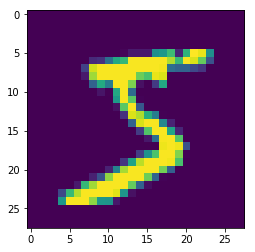

In [8]:
plt.imshow(train_x[0].reshape((28,28)))
plt.show

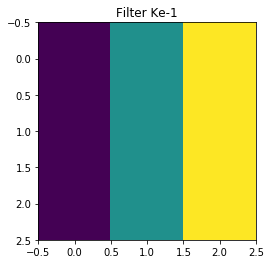

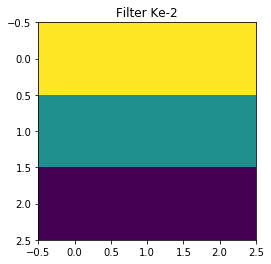

In [9]:
saring = np.zeros((2,3,3))
saring[0, :, :] = np.array([[[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]]])
saring[1, :, :] = np.array([[[1,   1,  1],
                                   [0,   0,  0],
                                   [-1, -1, -1]]])
plt.imshow(saring[0])
plt.title("Filter Ke-1")
plt.show()

plt.imshow(saring[1])
plt.title("Filter Ke-2")
plt.show()

In [10]:
def konvolusi(gambarInput):
    #Add Padding 1x1 Shape menjadi 30x30 dari asalnya 28x28
    gambar = gambarInput.reshape((28,28))
    gambarHasil = np.zeros((28+2*1, 28+2*1),dtype=gambar.dtype)
    gambarHasil[1:-1, 1:-1] = gambar


    #Konvolusi
    ukuranGambar = gambarHasil.shape[0]
    ukuranFilter = saring.shape[1]
    stridenya = 1
    ukuranHasilPerkalian = int((ukuranGambar - ukuranFilter)/stridenya)+1 
    hasilPerkalian = np.zeros((ukuranHasilPerkalian,ukuranHasilPerkalian))

    posisiYHasil = 0
    posisiYSekarang = 0
    while posisiYSekarang + ukuranFilter <= ukuranGambar:
        posisiXHasil = 0
        posisiXSekarang = 0
        while posisiXSekarang + ukuranFilter <= ukuranGambar:
            hasilPerkalianSaring1 = saring[0] * gambarHasil[posisiYSekarang:posisiYSekarang+ukuranFilter, posisiXSekarang:posisiXSekarang+ukuranFilter]
            hasilPerkalianSaring2 = saring[1] * gambarHasil[posisiYSekarang:posisiYSekarang+ukuranFilter, posisiXSekarang:posisiXSekarang+ukuranFilter]
            hasilPenjumlahanPerkalian = np.sum(hasilPerkalianSaring1) + np.sum(hasilPerkalianSaring1)
            
            #Relu jika kurang dari 0 jadikan 0
            if hasilPenjumlahanPerkalian < 0:
                hasilPerkalian[posisiYHasil, posisiXHasil] = 0
            else:
                hasilPerkalian[posisiYHasil, posisiXHasil] = hasilPenjumlahanPerkalian
                
            posisiXSekarang += stridenya
            posisiXHasil += 1
        posisiYSekarang += stridenya
        posisiYHasil += 1


    #Max Pooling
    stridenyaDownSampling = 2
    ukuranFilterDownSampling = 2
    ukuranGambarKonvolusi = hasilPerkalian.shape[0]
    ukuranHasilDownSampling = int((ukuranGambarKonvolusi - ukuranFilterDownSampling)/stridenyaDownSampling)+1 
    downSampling = np.zeros((ukuranHasilDownSampling,ukuranHasilDownSampling))


    posisiYHasil = 0
    posisiYSekarang = 0
    while posisiYSekarang + ukuranFilterDownSampling <= ukuranGambarKonvolusi:
        posisiXHasil = 0
        posisiXSekarang = 0
        while posisiXSekarang + ukuranFilterDownSampling <= ukuranGambarKonvolusi:
            downSampling[posisiYHasil, posisiXHasil] = np.max(hasilPerkalian[posisiYSekarang:posisiYSekarang+ukuranFilterDownSampling, posisiXSekarang:posisiXSekarang+ukuranFilterDownSampling])
            posisiXSekarang += stridenyaDownSampling
            posisiXHasil += 1
        posisiYSekarang += stridenyaDownSampling
        posisiYHasil += 1
    
    return np.array(downSampling).flatten()


In [11]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 101, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    if iteration == total: 
        print()    

In [12]:
hasilKonvolusiTrain = []
awal = 0
akhir = len(train_x)
for i in train_x:
    hasilKonvolusiTrain.append(konvolusi(i))
    awal +=1
    printProgressBar(awal, akhir, prefix = 'Konvolusi Train:', suffix = '(' + str(awal) + '/' + str(akhir) + ')', length = 80)

hasilKonvolusiTest = []
awal = 0
akhir = len(test_x)
for i in test_x:
    hasilKonvolusiTest.append(konvolusi(i))
    awal +=1
    printProgressBar(awal, akhir, prefix = 'Konvolusi Test:', suffix = '(' + str(awal) + '/' + str(akhir) + ')', length = 80)
    

In [20]:
def akurasi(X, Y):
    #Propagasi Maju
    #buat variabel untuk menampung perhitungan perkalian
    simpan = {}
    
    #buat transpose matrix data
    A = X.T
    #iterasi perhitungan silang data dengan bobot dan bias
    for jj in range(L-1):
        Z = parameter["W" + str(jj+1)].dot(A) + parameter["b" + str(jj + 1)]
        #Sigmoid
        A = 1 / (1 + np.exp(-Z))
        simpan["A" + str(jj + 1)] = A
        simpan["W" + str(jj + 1)] = parameter["W" + str(jj + 1)]
        simpan["Z" + str(jj + 1)] = Z
    
    
    Z = parameter["W" + str(L)].dot(A) + parameter["b" + str(L)]
    #Softmax
    exponenZ = np.exp(Z - np.max(Z))
    A = exponenZ / exponenZ.sum(axis=0, keepdims=True)
    simpan["A" + str(L)] = A
    simpan["W" + str(L)] = parameter["W" + str(L)]
    simpan["Z" + str(L)] = Z
    
    y_hat = np.argmax(A, axis=0)
    Y = np.argmax(Y, axis=1)
    akurasi = (y_hat == Y).mean()
    return [akurasi * 100]

def prediksi(X):
    #Propagasi Maju
    #buat variabel untuk menampung perhitungan perkalian
    simpan = {}
    
    #buat transpose matrix data
    A = X.T
    #iterasi perhitungan silang data dengan bobot dan bias
    for jj in range(L-1):
        Z = parameter["W" + str(jj+1)].dot(A) + parameter["b" + str(jj + 1)]
        #Sigmoid
        A = 1 / (1 + np.exp(-Z))
        simpan["A" + str(jj + 1)] = A
        simpan["W" + str(jj + 1)] = parameter["W" + str(jj + 1)]
        simpan["Z" + str(jj + 1)] = Z
    
    
    Z = parameter["W" + str(L)].dot(A) + parameter["b" + str(L)]
    #Softmax
    exponenZ = np.exp(Z - np.max(Z))
    A = exponenZ / exponenZ.sum(axis=0, keepdims=True)
    simpan["A" + str(L)] = A
    simpan["W" + str(L)] = parameter["W" + str(L)]
    simpan["Z" + str(L)] = Z

    y_hat = np.argmax(A, axis=0)
    return y_hat

In [150]:
#Pakek Konvolusi
hasilKonvolusiTrain = np.array(hasilKonvolusiTrain)
hasilKonvolusiTest = np.array(hasilKonvolusiTest)

#Ga pakek Konvolusi
# hasilKonvolusiTrain = train_x
# hasilKonvolusiTest = test_x

In [151]:
#Inisialisasi Variabel Parameter
#Ukuran Perceptron yang terakhir harus sama dengan jumlah class labelnya
ukuran_layer = [40,10]
parameter = {}
L = len(ukuran_layer)
n = hasilKonvolusiTrain.shape[1]
cost = []
lr = 0.1
iterasi = 200

In [152]:
#Inisialisasi nilai bobot dan bias
np.random.seed(1)
ukuran_layer.insert(0, hasilKonvolusiTrain.shape[1])
for l in range(1, len(ukuran_layer)):
    np.random.seed(1)
    parameter["W" + str(l)] = np.random.randn(ukuran_layer[l], ukuran_layer[l-1]) / np.sqrt(ukuran_layer[l-1])
    parameter["b" + str(l)] = np.zeros((ukuran_layer[l], 1))

In [153]:
#Iterasi Pelatihan
costs = []
costtest = []
ulangAwal = 0
ulangAkhir = 100
for i in range(iterasi):
    #Propagasi Maju
    #buat variabel untuk menampung perhitungan perkalian
    simpan = {}
    
    #buat transpose matrix data
    A = hasilKonvolusiTrain.T
    #iterasi perhitungan silang data dengan bobot dan bias
    for jj in range(L-1):
        #Perperceptron di kali dengan data di train ditambah dengan bias
        Z = parameter["W" + str(jj+1)].dot(A) + parameter["b" + str(jj + 1)]
        #Sigmoid
        A = 1 / (1 + np.exp(-Z))
        simpan["A" + str(jj + 1)] = A
        simpan["W" + str(jj + 1)] = parameter["W" + str(jj + 1)]
        simpan["Z" + str(jj + 1)] = Z
    
    
    Z = parameter["W" + str(L)].dot(A) + parameter["b" + str(L)]
    #Softmax
    exponenZ = np.exp(Z - np.max(Z))
    A = exponenZ / exponenZ.sum(axis=0, keepdims=True)
    simpan["A" + str(L)] = A
    simpan["W" + str(L)] = parameter["W" + str(L)]
    simpan["Z" + str(L)] = Z

    
    #Hitung Error Cost
    cost = -np.mean(train_y * np.log(A.T))
    
    #Propagasi balik
    derivative = {}
    simpan["A0"] = hasilKonvolusiTrain.T
    A = simpan["A" + str(L)]
    dZ = A - train_y.T

    dW = dZ.dot(simpan["A" + str(L - 1)].T) / n
    db = np.sum(dZ, axis=1, keepdims=True) / n
    dAPrev = simpan["W" + str(L)].T.dot(dZ)
    
    derivative["dW" + str(L)] = dW
    derivative["db" + str(L)] = db
    
    for j in range(L - 1, 0, -1):
        s = 1 / (1 + np.exp(simpan["Z" + str(j)]))
        dZ = dAPrev * (s * (1 - s))
        dW = 1. / n * dZ.dot(simpan["A" + str(j -1)].T)
        db = 1. / n * np.sum(dZ, axis=1, keepdims=True)
        
        if j > 1:
            dAPrev = simpan["W" + str(j)].T.dot(dZ)
        
        derivative["dW" + str(j)] = dW
        derivative["db" + str(j)] = db
    
    
    #Update bobot
    for jj in range(1, L + 1):
        parameter["W" + str(jj)] = parameter["W" + str(jj)] - lr * derivative["dW" + str(jj)]
        parameter["b" + str(jj)] = parameter["b" + str(jj)] - lr * derivative["db" + str(jj)]
        
    
    AA = hasilKonvolusiTest.T
    
    for jj in range(L-1):
        ZZ = parameter["W" + str(jj+1)].dot(AA) + parameter["b" + str(jj + 1)]
        AA = 1 / (1 + np.exp(-ZZ))
        
    ZZ = parameter["W" + str(L)].dot(AA) + parameter["b" + str(L)]
    exponenZZ = np.exp(ZZ - np.max(ZZ))
    AA = exponenZZ / exponenZZ.sum(axis=0, keepdims=True)

    costt = -np.mean(test_y * np.log(AA.T))
    
    ulangAwal = ulangAwal + 1
    
    printProgressBar(ulangAwal, ulangAkhir, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    
    if i % 100 == 0:
        ulangAwal = 0
        ulangAkhir = 100
        print( "(",(i),"/",iterasi,")", "loss : ", cost, "Train Accuracy : ", akurasi(hasilKonvolusiTrain, train_y))
        
    if i % 10 == 0:
        costs.append(cost)
        costtest.append(costt)
        

( 0 / 200 ) loss :  0.23805253388640743 Train Accuracy :  [16.496666666666666]
Progress: |██████████████████████████████████████████████████| 100.0% Complete
( 100 / 200 ) loss :  0.03666456327070057 Train Accuracy :  [90.83333333333333]


Train Accuracy: [93.90666666666667]
Test Accuracy: [93.56]
[0.23805253388640743, 0.22508826891442082, 0.17693003140262153, 0.08391426375087177, 0.05582426635445927, 0.0548408288590984, 0.04759576100846453, 0.03604544834854702, 0.03152924887596616, 0.03137087160845313, 0.03666456327070057, 0.02674798969773411, 0.02547515924154067, 0.024509375455118915, 0.024425076806046456, 0.04880182522735589, 0.03451697737240144, 0.023282804026530275, 0.0222614471313673, 0.021561503378866698]
[0.4155636535352861, 0.2317300298840399, 0.15514684116721786, 0.0801718227387935, 0.05295750328276621, 0.05646543712962984, 0.045985423469554025, 0.03425751644446912, 0.03045408255112652, 0.031951339845287405, 0.03082350132213927, 0.02615726558165037, 0.025053928290928024, 0.0242493475354256, 0.024446586985788527, 0.03912369696488625, 0.029622444027380998, 0.023306487873135835, 0.022428524466840457, 0.021799239127869113]


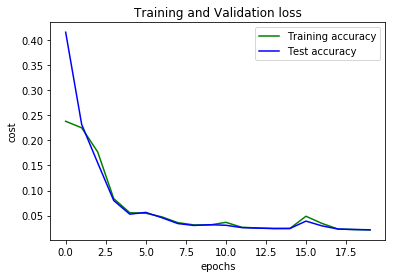

In [156]:
trainingnya = akurasi(hasilKonvolusiTrain, train_y)
testingnya = akurasi(hasilKonvolusiTest, test_y)
print("Train Accuracy:", trainingnya)
print("Test Accuracy:", testingnya)

print(costs)
print("=====================")
print(costtest)

plt.figure()
plt.plot(np.arange(len(costs)), costs, 'g', label='Training accuracy')
plt.plot(np.arange(len(costtest)), costtest, 'b', label='Test accuracy')
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

Hasil prediksi :  3
Jawaban dari test_y :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


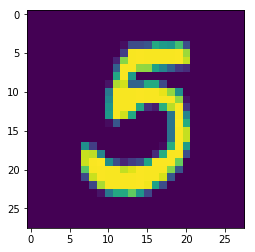

In [219]:
from random import randrange
index = randrange(0, 10000)
hasil = prediksi(hasilKonvolusiTest)

print("Hasil prediksi : " , hasil[index])
print("Jawaban dari test_y : " , test_y[index])
plt.imshow(test_x[index].reshape((28,28)))
plt.show()